# BatchNorm

refs:

[深度学习—BN的理解（一）](https://www.cnblogs.com/eilearn/p/9780696.html)

[深度学习（六）——BN算法（Batch Normalization）的原理和作用](https://blog.csdn.net/qq_37100442/article/details/81776191)

## 问题

　　机器学习领域有个很重要的假设：**IID独立同分布假设**，就是**假设训练数据和测试数据是满足相同分布的**，这是通过训练数据获得的模型能够在测试集获得好的效果的一个基本保障。那BatchNorm的作用是什么呢？BatchNorm就是在深度神经网络训练过程中**使得每一层神经网络的输入保持相同分布的**。

　　**思考一个问题：为什么传统的神经网络在训练开始之前，要对输入的数据做Normalization?**原因在于神经网络学习过程本质上是为了学习数据的分布，一旦训练数据与测试数据的分布不同，那么网络的泛化能力也大大降低；另一方面，一旦在mini-batch梯度下降训练的时候，每批训练数据的分布不相同，那么网络就要在每次迭代的时候去学习以适应不同的分布，这样将会大大降低网络的训练速度，这也正是为什么我们需要对所有训练数据做一个Normalization预处理的原因。

　　**为什么深度神经网络随着网络深度加深，训练起来越困难，收敛越来越慢？**这是个在DL领域很接近本质的好问题。很多论文都是解决这个问题的，比如ReLU激活函数，再比如Residual Network，BN本质上也是解释并从某个不同的角度来解决这个问题的。

　　**结论：BN 层在激活函数之前。BN层的作用机制也许是通过平滑隐藏层输入的分布，帮助随机梯度下降的进行，缓解随机梯度下降权重更新对后续层的负面影响。**因此，实际上，**无论是放非线性激活之前，还是之后**，也许都能发挥这个作用。只不过，**取决于具体激活函数的不同**，效果也许有一点差别（比如，对sigmoid和tanh而言，放非线性激活之前，也许顺便还能缓解sigmoid/tanh的梯度衰减问题，而对ReLU而言，这个平滑作用经ReLU“扭曲”之后也许有所衰弱）。

　　（1）sigmoid、tanh 激活函数。函数图像的两端，相对于x的变化，y的变化都很小（这其实很正常，毕竟tanh就是拉伸过的sigmoid）。也就是说，容易出现梯度衰减的问题。那么，如果在tanh或sigmoid之前，进行一些normalization处理，就可以缓解梯度衰减的问题。我想这可能也是最初的BN论文选择把BN层放在非线性激活之前的原因。

　　（2）relu激活函数。所以，现在我们假设所有的激活都是relu，也就是使得负半区的卷积值被抑制，正半区的卷积值被保留。而bn的作用是使得输入值的均值为０，方差为１，也就是说假如relu之前是bn的话，会有接近一半的输入值被抑制，一半的输入值被保留。

　　所以bn放到relu之前的好处可以这样理解：bn可以防止某一层的激活值全部都被抑制，从而防止从这一层往前传的梯度全都变成０，也就是防止梯度消失。（当然也可以防止梯度爆炸）

## “Internal Covariate Shift”问题

　　从论文名字可以看出，BN是用来解决**“Internal Covariate Shift”**问题的，那么首先得理解什么是“Internal Covariate Shift”？

　　论文首先说明Mini-Batch SGD相对于One Example SGD的**两个优势：梯度更新方向更准确；并行计算速度快；**（为什么要说这些？因为BatchNorm是基于Mini-Batch SGD的，所以先夸下Mini-Batch SGD，当然也是大实话）；然后吐槽下SGD训练的缺点：超参数调起来很麻烦。（作者隐含意思是用BN就能解决很多SGD的缺点）

　　接着引入**covariate shift的概念**：如果ML系统实例集合<X,Y>中的输入值X的分布老是变，这不符合IID假设，网络模型很难稳定的学规律，这不得引入迁移学习才能搞定吗，我们的ML系统还得去学习怎么迎合这种分布变化啊。对于深度学习这种包含很多隐层的网络结构，在训练过程中，因为各层参数不停在变化，**所以每个隐层都会面临covariate shift的问题**，也就是在训练过程中，隐层的输入分布老是变来变去，这就是所谓的“Internal Covariate Shift”，Internal指的是深层网络的隐层，是发生在网络内部的事情，而不是covariate shift问题只发生在输入层。

　　然后提出了**BatchNorm的基本思想**：能不能让每个隐层节点的激活输入分布固定下来呢？这样就避免了“Internal Covariate Shift”问题了，顺带解决反向传播中梯度消失问题。BN 其实就是在做 feature scaling，而且它的目的也是为了在训练的时候避免这种 Internal Covariate Shift 的问题，只是刚好也解决了 sigmoid 函数梯度消失的问题。

　　BN不是凭空拍脑袋拍出来的好点子，它是有启发来源的：之前的研究表明如果在图像处理中对输入图像进行**白化（Whiten）**操作的话——所谓白化，就是对输入数据分布变换到0均值，单位方差的正态分布——那么神经网络会较快收敛，那么BN作者就开始推论了：图像是深度神经网络的输入层，做白化能加快收敛，那么其实对于深度网络来说，其中某个隐层的神经元是下一层的输入，意思是其实深度神经网络的每一个隐层都是输入层，不过是相对下一层来说而已，那么能不能对每个隐层都做白化呢？这就是启发BN产生的原初想法，而BN也确实就是这么做的，可以理解为对深层神经网络每个隐层神经元的激活值做简化版本的白化操作。

## BatchNorm的本质思想

　　**BN的基本思想其实相当直观**：因为深层神经网络在做非线性变换前的激活输入值（就是那个x=WU+B，U是输入）随着网络深度加深或者在训练过程中，其**分布逐渐发生偏移或者变动**，**之所以训练收敛慢，一般是整体分布逐渐往非线性函数的取值区间的上下限两端靠近（对于Sigmoid函数来说，意味着激活输入值WU+B是大的负值或正值），所以这导致反向传播时低层神经网络的梯度消失，这是训练深层神经网络收敛越来越慢的本质原因**，而BN就是通过一定的规范化手段，把每层神经网络任意神经元这个输入值的**分布强行拉回到均值为0方差为1的标准正态分布**，其实就是把越来越偏的分布强制拉回比较标准的分布，这样使得激活输入值落在非线性函数对输入比较敏感的区域，这样输入的小变化就会导致损失函数较大的变化，意思是这样让梯度变大，避免梯度消失问题产生，而且梯度变大意味着学习收敛速度快，能大大加快训练速度。

　　THAT’S IT。其实一句话就是：**对于每个隐层神经元，把逐渐向非线性函数映射后向取值区间极限饱和区靠拢的输入分布强制拉回到均值为0方差为1的比较标准的正态分布，使得非线性变换函数的输入值落入对输入比较敏感的区域，以此避免梯度消失问题**。因为梯度一直都能保持比较大的状态，所以很明显对神经网络的参数调整效率比较高，就是变动大，就是说向损失函数最优值迈动的步子大，也就是说收敛地快。BN说到底就是这么个机制，方法很简单，道理很深刻。

　　从上面几个图应该看出来BN在干什么了吧？**其实就是把隐层神经元激活输入x=WU+B从变化不拘一格的正态分布通过BN操作拉回到了均值为0，方差为1的正态分布，即原始正态分布中心左移或者右移到以0为均值，拉伸或者缩减形态形成以1为方差的图形**。什么意思？**就是说经过BN后，目前大部分Activation的值落入非线性函数的线性区内，其对应的导数远离导数饱和区，这样来加速训练收敛过程**。

　　但是很明显，看到这里，稍微了解神经网络的读者一般会提出一个疑问：如果都通过BN，那么不就跟把非线性函数替换成线性函数效果相同了？这意味着什么？我们知道，如果是多层的线性函数变换其实这个深层是没有意义的，因为多层线性网络跟一层线性网络是等价的。这意味着网络的表达能力下降了，这也意味着深度的意义就没有了。所以**BN为了保证非线性的获得，对变换后的满足均值为0方差为1的x又进行了scale加上shift操作(y=scale*x+shift)，每个神经元增加了两个参数scale和shift参数，这两个参数是通过训练学习到的**，意思是通过scale和shift把这个值从标准正态分布左移或者右移一点并长胖一点或者变瘦一点，每个实例挪动的程度不一样，这样等价于非线性函数的值从正中心周围的线性区往非线性区动了动。

　　**核心思想应该是想找到一个线性和非线性的较好平衡点，既能享受非线性的较强表达能力的好处，又避免太靠非线性区两头使得网络收敛速度太慢**。当然，这是我的理解，论文作者并未明确这样说。但是很明显这里的scale和shift操作是会有争议的，因为按照论文作者论文里写的理想状态，就会又通过scale和shift操作把变换后的x调整回未变换的状态，那不是饶了一圈又绕回去原始的“Internal Covariate Shift”问题里去了吗，感觉论文作者并未能够清楚地解释scale和shift操作的理论原因。

## 训练阶段如何做BatchNorm
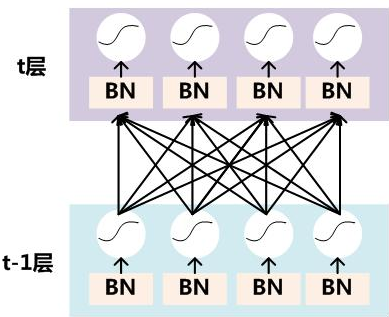
对于Mini-Batch SGD来说，一次训练过程里面包含m个训练实例，其具体BN操作就是对于隐层内每个神经元的激活值来说，进行如下变换：
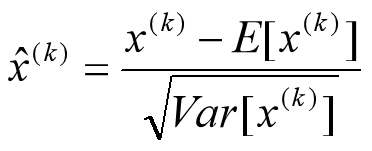
　　要注意，这里t层某个神经元的x(k)不是指原始输入，就是说不是t-1层每个神经元的输出，而是t层这个神经元的线性激活x=WU+B，这里的U才是t-1层神经元的输出。变换的意思是：某个神经元对应的原始的激活x通过减去mini-Batch内m个实例获得的m个激活x求得的均值E(x)并除以求得的方差Var(x)来进行转换。

　　上文说过经过这个变换后某个神经元的激活x形成了均值为0，方差为1的正态分布，目的是把值往后续要进行的非线性变换的线性区拉动，增大导数值，增强反向传播信息流动性，加快训练收敛速度。但是这样会导致网络表达能力下降，为了防止这一点，每个神经元增加两个调节参数（scale和shift），这两个参数是通过训练来学习到的，用来对变换后的激活反变换，使得网络表达能力增强，即对变换后的激活进行如下的scale和shift操作，这其实是变换的反操作：
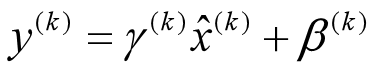
BN其具体操作流程，如论文中描述的一样：
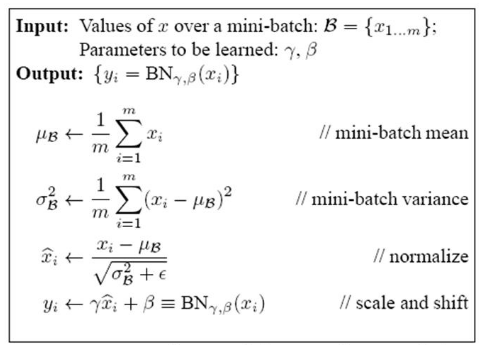
走一遍Batch Normalization网络层的前向传播过程。
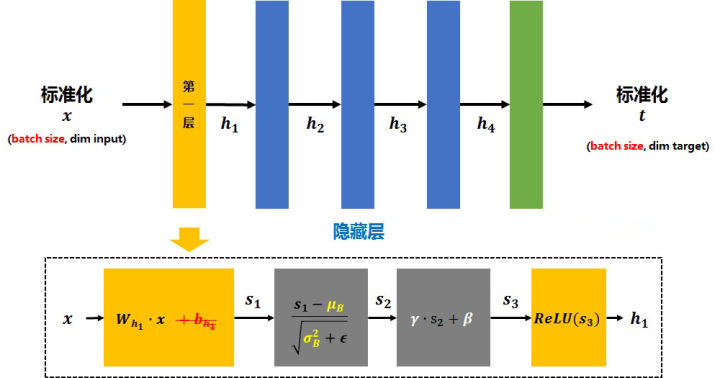

## BatchNorm的推理(Inference)过程

　　BN在训练的时候可以根据Mini-Batch里的若干训练实例进行激活数值调整，但是在推理（inference）的过程中，很明显输入就只有一个实例，看不到Mini-Batch其它实例，那么这时候怎么对输入做BN呢？因为很明显一个实例是没法算实例集合求出的均值和方差的。这可如何是好？既然没有从Mini-Batch数据里可以得到的统计量，那就想其它办法来获得这个统计量，就是均值和方差。可以用从所有训练实例中获得的统计量来代替Mini-Batch里面m个训练实例获得的均值和方差统计量，因为本来就打算用全局的统计量，只是因为计算量等太大所以才会用Mini-Batch这种简化方式的，那么在推理的时候直接用全局统计量即可。

　　决定了获得统计量的数据范围，那么接下来的问题是如何获得均值和方差的问题。很简单，因为每次做Mini-Batch训练时，都会有那个Mini-Batch里m个训练实例获得的均值和方差，现在要全局统计量，只要把每个Mini-Batch的均值和方差统计量记住，然后对这些均值和方差求其对应的数学期望即可得出全局统计量

## BatchNorm的好处

BatchNorm为什么NB呢，关键还是效果好。

**①不仅仅极大提升了训练速度，收敛过程大大加快**；

**②还能增加分类效果，一种解释是这是类似于Dropout的一种防止过拟合的正则化表达方式，所以不用Dropout也能达到相当的效果**；

**③另外调参过程也简单多了，对于初始化要求没那么高，而且可以使用大的学习率等**。

**➃能够一定程度减少梯度消失**。

总而言之，经过这么简单的变换，带来的好处多得很，这也是为何现在BN这么快流行起来的原因。

## tensorflow中的BN

　　为了activation能更有效地使用输入信息，所以一般BN放在激活函数之前。

　　 一个batch里的128个图，经过一个64 kernels卷积层处理，得到了128×64个图，再针对每一个kernel所对应的128个图，求它们所有像素的mean和variance，因为总共有64个kernels，输出的结果就是一个一维长度64的数组啦！最后输出是（64，）的数组向量。
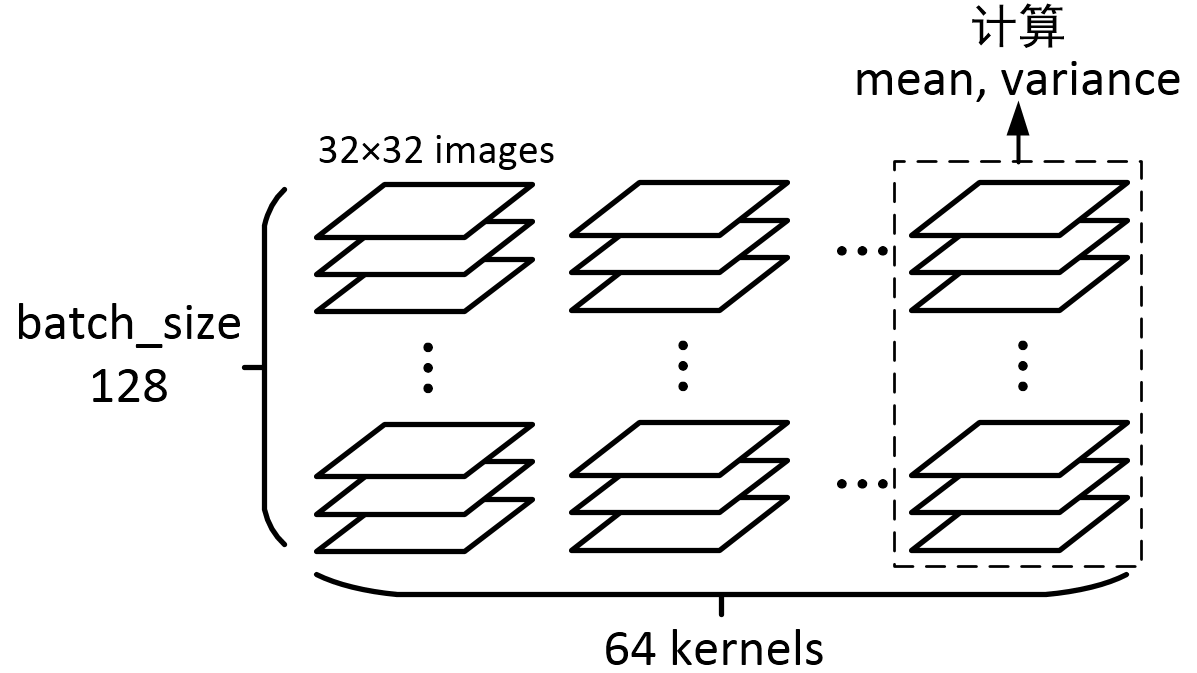